In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import glob
elements = glob.glob("/content/drive/MyDrive/AudioSamples/AudioSamples/Lists/NoFX/*.xml")


In [ ]:
from xml.etree import ElementTree as ET
import glob
import numpy as np
path1 = "./Dataset/Lists/NoFX/*.xml"
path2 = "./Dataset/Lists/Distortion/*.xml"
path3 = "./Dataset/Lists/Tremolo/*.xml"



def print_label(path=""):
    arr=[]
    elements = glob.glob(path)
    for i in elements:
        xml = ET.parse(i)
        root_element = xml.getroot()
        for page in root_element.findall('audiofile'):
            arr.append(page.find('fxgroup').text)
    #  print("Effetto: ", page.find('fxgroup').text)  
    return arr

# array1 = print_label(path = path1)
# array2 = print_label(path = path2)
# array3 = print_label(path = path3)
#print(array1)
#print(array2)
#print(array3)

In [ ]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import sklearn.svm
from sklearn.model_selection import train_test_split
import IPython.display as ipd
import scipy as sp

In [ ]:
def compute_mfcc(audio, fs, n_mfcc):
    # Compute the spectrogram of the audio signal
    X = np.abs(librosa.stft(
        audio,
        window='hamming',
        n_fft=1024,
        hop_length=512,)
        )
    
    # Find the weights of the mel filters
    mel = librosa.filters.mel(
        sr=fs,
        n_fft=1024,
        n_mels=40,
        fmin=133.33,
        fmax=6853.8,
    )
    
    # Apply the filters to spectrogram
    melspectrogram = np.dot(mel, X)
    # Take the logarithm
    log_melspectrogram = np.log10(melspectrogram + 1e-16)
    
    # Apply the DCT to log melspectrogram to obtain the coefficients
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1:n_mfcc+1]
    return mfcc

In [ ]:
classes = ['NoFX', 'Distortion', 'Tremolo']
n_mfcc = 13
dict_train_features = {'NoFX': [], 'Distortion': [], 'Tremolo': []}
dict_test_features = {'NoFX': [], 'Distortion': [], 'Tremolo': []}

X_root_2 = './Dataset/Tremolo/'
X_2 = [f for f in os.listdir(X_root_2) if f.endswith('.wav')]
array3 = np.ones(len(X_2))*2

X_root_1 = './Dataset/Distortion/'
X_1 = [g for g in os.listdir(X_root_1) if g.endswith('.wav')]
array2 = np.ones(len(X_1))

X_root_0 = './Dataset/NoFX/'
X_0 = [h for h in os.listdir(X_root_0) if h.endswith('.wav')]
X_0 = X_0*3
array1 = np.zeros(len(X_0))


X_train_0, X_test_0, y_train_0, y_test_0 = sklearn.model_selection.train_test_split(X_0, array1, test_size=0.5, train_size=0.5, shuffle=True)
X_train_1, X_test_1, y_train_1, y_test_1 = sklearn.model_selection.train_test_split(X_1, array2, test_size=0.5, train_size=0.5, shuffle=True)
X_train_2, X_test_2, y_train_2, y_test_2 = sklearn.model_selection.train_test_split(X_2, array3, test_size=0.5, train_size=0.5, shuffle=True)

# print(len(X_train_1))
# print(array1)


In [ ]:
dict_1 = {'NoFX': X_train_0, 'Distortion': X_train_1, 'Tremolo': X_train_2}
dict_2 = {'NoFX': X_root_0, 'Distortion': X_root_1, 'Tremolo': X_root_2}
for c in classes:
    n_train_samples=len(dict_1[c])
    train_features = np.zeros((n_train_samples, n_mfcc))
    for index, f in enumerate(dict_1[c]):
        audio, fs = librosa.load(os.path.join(dict_2[c], f), sr=None)
        mfcc = compute_mfcc(audio, fs, n_mfcc)
        train_features[index, :] = np.mean(mfcc, axis=1)
    dict_train_features[c] = train_features

dict_3 = {'NoFX': X_test_0, 'Distortion': X_test_1, 'Tremolo': X_test_2}

for c in classes:
    n_test_samples=len(dict_3[c])
    test_features = np.zeros((n_test_samples, n_mfcc))
    for index, f in enumerate(dict_3[c]):
        audio, fs = librosa.load(os.path.join(dict_2[c], f), sr=None)
        mfcc = compute_mfcc(audio, fs, n_mfcc)
        test_features[index, :] = np.mean(mfcc, axis=1)
    dict_test_features[c] = test_features
    
y_test_mc = np.concatenate((y_test_0, y_test_1, y_test_2), axis=0)

In [ ]:
class_0 = 'NoFX'
class_1 = 'Distortion'
class_2 = 'Tremolo'

X_train_0 = dict_train_features[class_0]
X_train_1 = dict_train_features[class_1]
X_train_2 = dict_train_features[class_2]

X_test_0 = dict_test_features[class_0]
X_test_1 = dict_test_features[class_1]
X_test_2 = dict_test_features[class_2]

feat_max = np.max(np.concatenate((X_train_0, X_train_1, X_train_2), axis=0), axis=0)
feat_min = np.min(np.concatenate((X_train_0, X_train_1, X_train_2), axis=0), axis=0)

X_train_0_normalized = (X_train_0 - feat_min) / (feat_max - feat_min)
X_train_1_normalized = (X_train_1 - feat_min) / (feat_max - feat_min)
X_train_2_normalized = (X_train_2 - feat_min) / (feat_max - feat_min)

X_test_0_normalized = (X_test_0 - feat_min) / (feat_max - feat_min)
X_test_1_normalized = (X_test_1 - feat_min) / (feat_max - feat_min)
X_test_2_normalized = (X_test_2 - feat_min) / (feat_max - feat_min)

X_test_mc_normalized = np.concatenate((X_test_0_normalized, X_test_1_normalized, X_test_2_normalized), axis=0)


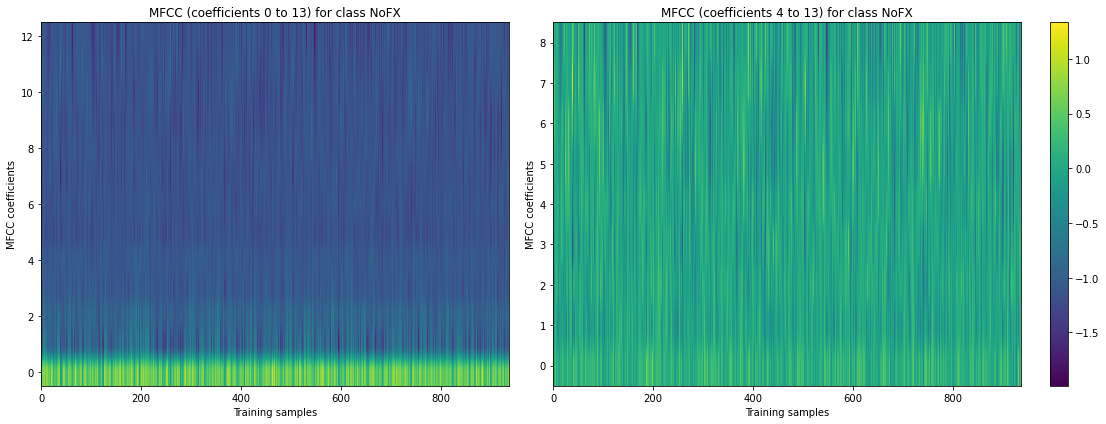

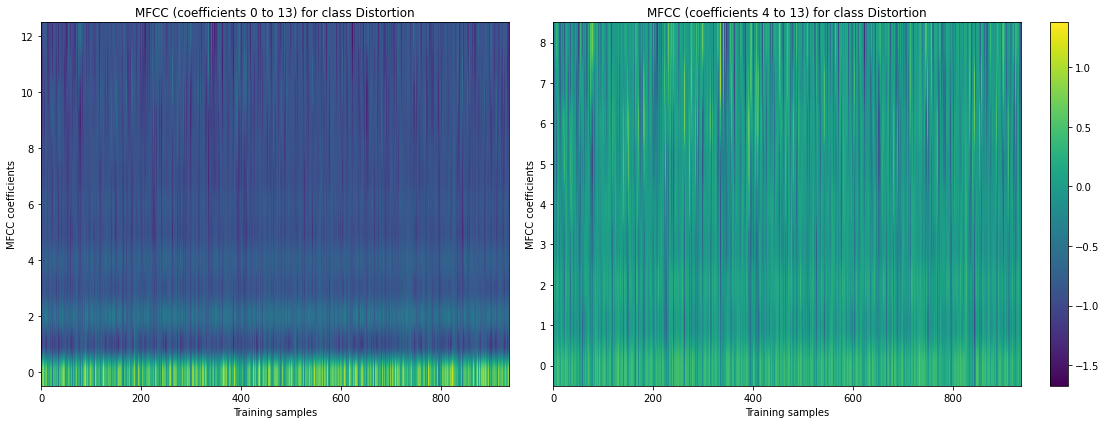

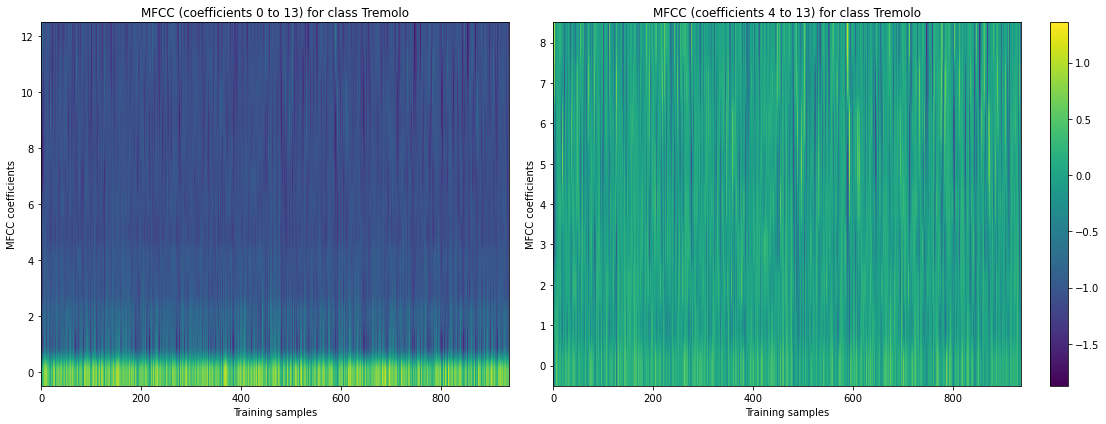

In [ ]:
for c in classes:
    mfcc = dict_train_features[c].transpose()
    # Visualization
    fig = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC (coefficients 0 to 13) for class {}'.format(c))
    plt.colorbar()
    plt.tight_layout()

    mfcc_upper = mfcc[4:]
    plt.subplot(1,2,2)
    plt.imshow(mfcc_upper, origin='lower', aspect='auto')
    plt.title('MFCC (coefficients 4 to 13) for class {}'.format(c))
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.colorbar()
    plt.tight_layout()

In [ ]:
SVM_parameters={
    'C': 1,
    'kernel': 'rbf',
}

clf_01 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_02 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_12 = sklearn.svm.SVC(**SVM_parameters, probability=True)
print(clf_01)

SVC(C=1, probability=True)


In [ ]:
clf_01.fit(np.concatenate((X_train_0_normalized, X_train_1_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_1), axis=0))
           
clf_02.fit(np.concatenate((X_train_0_normalized, X_train_2_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_2), axis=0))

clf_12.fit(np.concatenate((X_train_1_normalized, X_train_2_normalized), axis=0), 
           np.concatenate((y_train_1, y_train_2), axis=0))

SVC(C=1, probability=True)

In [ ]:
y_test_predicted_01 = clf_01.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_02 = clf_02.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_12 = clf_12.predict(X_test_mc_normalized).reshape(-1, 1)
print(y_test_predicted_01)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [ ]:
y_test_predicted_mc = np.concatenate((y_test_predicted_01, y_test_predicted_02, y_test_predicted_12), axis=1)
y_test_predicted_mc = np.array(y_test_predicted_mc, dtype=np.int)

In [ ]:
y_test_predicted_mv = np.zeros((y_test_predicted_mc.shape[0],))
for i, e in enumerate(y_test_predicted_mc):
    y_test_predicted_mv[i] = np.bincount(e).argmax() 

In [ ]:
def compute_cm_multiclass(gt, predicted):
    classes = np.unique(gt)
    
    CM = np.zeros((len(classes), len(classes)))
    
    for i in np.arange(len(classes)):
        pred_class = predicted[gt==i]
        
        for j in np.arange(len(pred_class)):
            CM[i, int(pred_class[j])] = CM[i, int(pred_class[j])] + 1 
    print(CM)

In [ ]:
compute_cm_multiclass(y_test_mc, y_test_predicted_mv)

[[444.  25. 467.]
 [ 21. 893.  22.]
 [411.  22. 503.]]
